In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio

from mpl_toolkits.axes_grid.inset_locator import inset_axes

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_97139/3962609772.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


# Loading Data

In [2]:
def normalize(data, colName):
    data[colName] = (data[colName] - np.min(data[colName]))/ (np.max(data[colName]) - np.min(data[colName]))

def standardize(df, colName, newColName):
    df[newColName] =( df[colName] - df[colName].mean() ) / df[colName].std()

def findIntOrder(targetDf,trgtIdx):
    img = targetDf.loc[trgtIdx,'presentedImgs']
    seg = targetDf.loc[trgtIdx,'segPos'] - 1

    segImg = np.zeros((10,10))

    for i in range(len(seg)):
        row = seg[i,0]
        col = seg[i,1]

        segImg[row, col] = img[row, col]

    # Find the intensity order of the shown segment
    intOrder = np.max(segImg)

    return intOrder

def regenerateImgs(df,trgt):
    img = df.loc[trgt, 'segIntensity']
    seg = df.loc[trgt, 'segPos'] - 1 

    segImg = np.zeros((10,10))

    for i in range(len(seg)):
        row = seg[i,0]
        col = seg[i,1]

        segImg[row, col] = img[row, col]

    return segImg

def r_2(y_acc, y_model):
    residuals = y_acc - y_model
    SumResSquared = np.sum(residuals**2)
    TotalSumSquares = np.sum((y_acc - np.mean(y_acc))**2)
    RSquared = 1 - (SumResSquared/TotalSumSquares)

    return RSquared

# compute discrete integral
def compute_probs(trgt_pred):
    for col in [0,2]:
        probs = [0]
        integ = 0    
        i = 0
        
        while i < (len(trgt_pred)-2):                    
            # for short and long exposure time
            area = (trgt_pred.iloc[i + 1,col] - trgt_pred.iloc[i,col]) * trgt_pred.iloc[i + 1, col+1] 
            integ = area + integ
            probs.append(area)
        
            i = i + 1

        # Here complete it to 1, check it again
        probs.append((1-np.sum(probs)))

        if col == 0:
            trgt_pred['prob_short'] = probs
        else:
            trgt_pred['prob_long'] = probs

def normalize(data):    
    output = (data - np.min(data))/ (np.max(data) - np.min(data))
    return output

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post')
    plt.grid(True)
    plt.savefig('ecdf.png')


def find_closest_number(arr, num):
    idx = np.abs(arr - num).argmin()
    return idx

In [3]:
file_pth ='data/all.csv'
df = pd.read_csv(file_pth)
df['eff_label'] = pd.cut(x=df['effortAll'], bins=[0, 0.048, 0.06, 13],
                     labels=['Easy', 'Normal', 'Difficult'])

In [4]:
# Store contrast values
idsAll = ['da','eb', 'go', 'js', 'mae', 're']
cntrst_all = [0.0384, 0.0175, 0.0276, 0.0197, 0.0160, 0.0121]

cntrst = dict()
for i, id in enumerate(idsAll):
    cntrst[id] = cntrst_all[i]

In [5]:
file_pth = 'data/all_img_cumNcuts.csv'

# Load all the cumulative Ncut values
allImgs = pd.read_csv(file_pth, header= None)

imgColNames = ['imgId', 'cutNo', 'ncut', 'stab','cumNcut']
allImgs.columns = imgColNames


# Specify Plotting Setings

In [6]:
allParticipants = ['eb', 'go', 'mae', 're','js', 'da']
colorShort = '#3BCEAC'
colorLong = '#EE4266'

colorMap = {"eb": 'tab:olive',
         "go": 'tab:cyan',
         "mae":'tab:red',
         "re": 'tab:grey',
         "da": 'brown',
         "js": 'tab:pink'
        }

colorMap = {"eb": '#241623',
         "go": '#D0CD94',
         "mae":'#3C787E',
         "re": '#C7EF00',
         "da": '#D56F3E',
         "js": 'tab:pink'
        }

legendLabels = ['E.B.', 'G.O.', 'M.A.E.', 'R.E.','D.A.','J.S.']

dotSize = 160

fontSizeLegend = 17
fontSizeLabel = 17
fontSizeTitle = 20

# Plot Behavioral Stats

## Test Trials

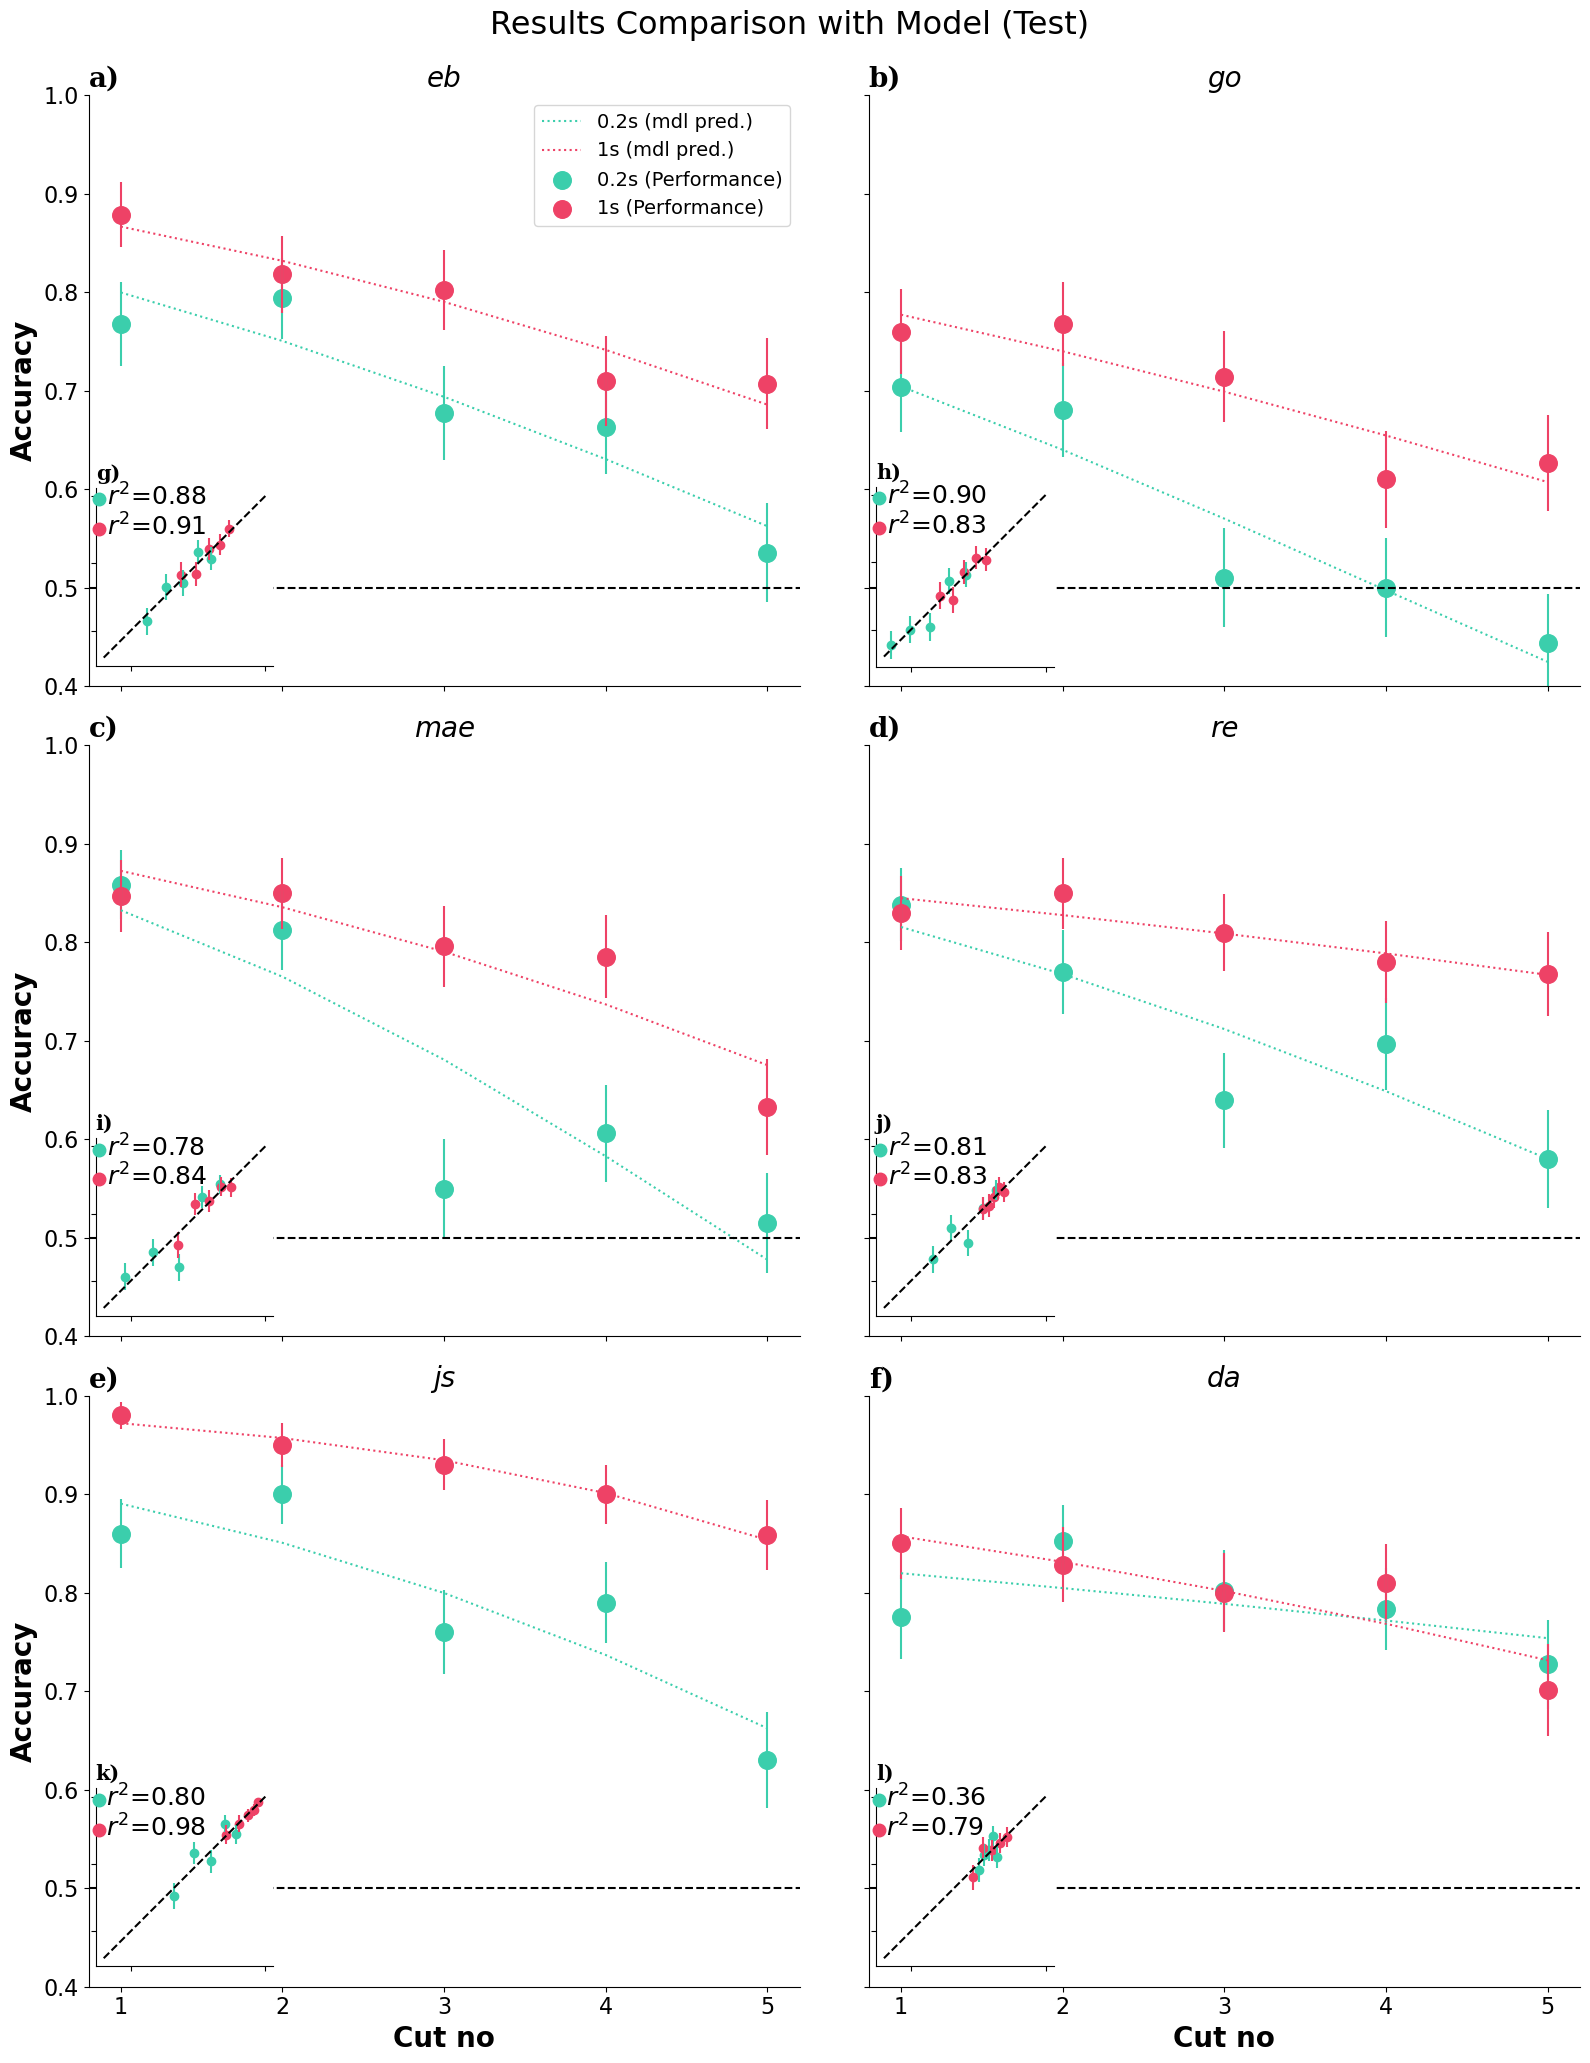

In [7]:
plotTitles = ['a)', 'b)', 'c)', 'd)', 'e)','f)']
subplotTitles = ['g)', 'h)', 'i)', 'j)', 'k)','l)']

cntrl = 0
comp_model = 'pHat_cutNo'


fig, axes = plt.subplots(3,2, figsize = (16,21), sharex=True, sharey=True)
axes = axes.ravel()


for i in range(len(allParticipants)):
        
    participantId = allParticipants[i]
    
    error = df.groupby(['participantID','cutNo','expTime','control'],as_index=False)['correct'].sem()
    error_short = error.loc[(error['expTime'] == 0.2) & (error['control'] == cntrl) & (error['participantID'] == participantId), 'correct']
    error_long =  error.loc[(error['expTime'] == 1) & (error['control'] == cntrl) & (error['participantID'] == participantId), 'correct']

    y_mean = df.groupby(['participantID','cutNo','expTime','control'],as_index=False)['correct'].mean()
    y_mean_short = y_mean.loc[(y_mean['expTime'] == 0.2) & (y_mean['control'] == cntrl) & (y_mean['participantID'] == participantId),'correct']
    y_mean_long = y_mean.loc[(y_mean['expTime'] == 1) & (y_mean['control'] == cntrl) & (y_mean['participantID'] == participantId),'correct']


    y_model_mean = df.groupby(['participantID','cutNo','expTime','control'],as_index=False)[comp_model].mean()
    y_model_short = y_model_mean.loc[(y_model_mean['expTime'] == 0.2) & (y_model_mean['control'] == cntrl)& (y_model_mean['participantID'] == participantId) ,comp_model]
    y_model_long = y_model_mean.loc[(y_model_mean['expTime'] == 1) & (y_model_mean['control'] == cntrl) & (y_model_mean['participantID'] == participantId), comp_model]

    
    ## Compute R^2
    short_r2 = r_2(y_mean_short, y_model_short)
    long_r2 = r_2(y_mean_long, y_model_long)


    x = np.arange(1,6)

    axes[i].errorbar(x, y_mean_short, yerr = error_short, fmt = 'none', c = colorShort)
    axes[i].scatter(x, y_mean_short, label = '0.2s (Performance)', s = dotSize ,c = colorShort)
    #axes[i].set_xlabel('cut no')
    #axes[i].set_ylabel('Accuracy')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    axes[i].errorbar(x, y_mean_long, yerr = error_long, fmt = 'none', c = colorLong)
    axes[i].scatter(x, y_mean_long, label = '1s (Performance)', s = dotSize, c = colorLong)    
    #axes[i].set_ylabel('Accuracy')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    axes[i].plot(x, y_model_short, linestyle='dotted', label = '0.2s (mdl pred.)', c = colorShort)
    axes[i].plot(x, y_model_long, linestyle='dotted', label = '1s (mdl pred.)', c = colorLong)

    axes[i].set_xticks(np.arange(1,6))
    axes[i].axhline(0.5,ls = '--', color = 'k')    
    
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    #axes[i].set_title('{}'.format(participantId), fontsize = 15, fontweight="bold")
    axes[i].set_title('{}'.format(participantId), fontsize = fontSizeTitle, style = 'italic')
    axes[i].set_title(plotTitles[i], fontfamily='serif', loc='left', fontsize = fontSizeTitle, fontweight = 'bold')
    axes[i].set_ylim(bottom = 0.4, top = 1)
    

    ## Add r^2 plots
    # Add small plots        
    error = df.groupby(['participantID','cutNo','expTime','control'],as_index=False)['correct'].sem()
    error_short = error.loc[(error['expTime'] == 0.2) & (error['control'] == 0) & (error['participantID'] == participantId), 'correct']
    error_long =  error.loc[(error['expTime'] == 1) & (error['control'] == 0) & (error['participantID'] == participantId), 'correct']

    y_mean = df.groupby(['participantID','cutNo','expTime','control'],as_index=False)['correct'].mean()
    y_mean_short = y_mean.loc[(y_mean['expTime'] == 0.2) & (y_mean['control'] == 0) & (y_mean['participantID'] == participantId),'correct']
    y_mean_long = y_mean.loc[(y_mean['expTime'] == 1) & (y_mean['control'] == 0) & (y_mean['participantID'] == participantId),'correct']


    y_model_mean = df.groupby(['participantID','cutNo','expTime','control'],as_index=False)['pHat_cutNo'].mean()
    y_model_short = y_model_mean.loc[(y_model_mean['expTime'] == 0.2) & (y_model_mean['control'] == 0)& (y_model_mean['participantID'] == participantId) ,'pHat_cutNo']
    y_model_long = y_model_mean.loc[(y_model_mean['expTime'] == 1) & (y_model_mean['control'] == 0) & (y_model_mean['participantID'] == participantId),'pHat_cutNo']
    

    ident = [0.4, 1.0]
    
    # this is an inset axes over the main axes
    inset = axes[i].inset_axes([0.01, 0.01, 0.25, 0.35])

    inset.errorbar(y_model_short, y_mean_short, yerr = error_short, fmt = 'none', c = colorShort)
    inset.scatter(y_model_short, y_mean_short, label=r'$r^2$={:.2f}'.format(short_r2), c = colorShort)    
    inset.spines['top'].set_visible(False)
    inset.spines['right'].set_visible(False)

    inset.errorbar(y_model_long, y_mean_long, yerr = error_long, fmt = 'none', c = colorLong)
    inset.scatter(y_model_long, y_mean_long, label=r'$r^2$={:.2f}'.format(long_r2), c = colorLong) 
    inset.spines['top'].set_visible(False)
    inset.spines['right'].set_visible(False)

    inset.tick_params(axis='both', which='major', labelsize=18)
    inset.plot(ident,ident, 'k--')
    inset.set_yticklabels([])
    inset.set_xticklabels([])    
    #inset.legend(fontsize = 'x-small', loc = 'lower right', bbox_to_anchor=(3.5, 2.1), frameon = True, columnspacing = 1)
    inset.set_title(subplotTitles[i], fontfamily='serif', loc='left',fontsize = 15, fontweight = 'bold' )
    #inset.set_title('{}'.format(participantId), fontsize = 15, fontweight='bold' )
    inset.set_aspect('equal', adjustable='box')
    inset.legend(loc = 'upper right', bbox_to_anchor=(0.75, 1.15), frameon = False, handletextpad = -0.7, fontsize = 18, labelspacing = 0.1, markerscale = 1.5)

#axes[i].legend()

axes[0].set_ylabel('Accuracy', fontsize=20,fontweight='bold' )
axes[2].set_ylabel('Accuracy', fontsize=20, fontweight='bold' )
axes[4].set_ylabel('Accuracy', fontsize=20, fontweight='bold' )
axes[4].set_xlabel('Cut no', fontsize=20, fontweight='bold' )
axes[5].set_xlabel('Cut no', fontsize=20, fontweight='bold' )
axes[0].legend(loc = 'upper right', title_fontsize='large', prop={'size':14})

#fig.suptitle('Results Comparison with Model (Test) \n' + r'$\it{glm(correct \sim cut No * Exposure Time)}$', fontsize = 15)
fig.suptitle('Results Comparison with Model (Test) \n', fontsize = 23)
plt.tight_layout()

figname = 'figs/thesis/'+'test_all.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)


## Control Trials

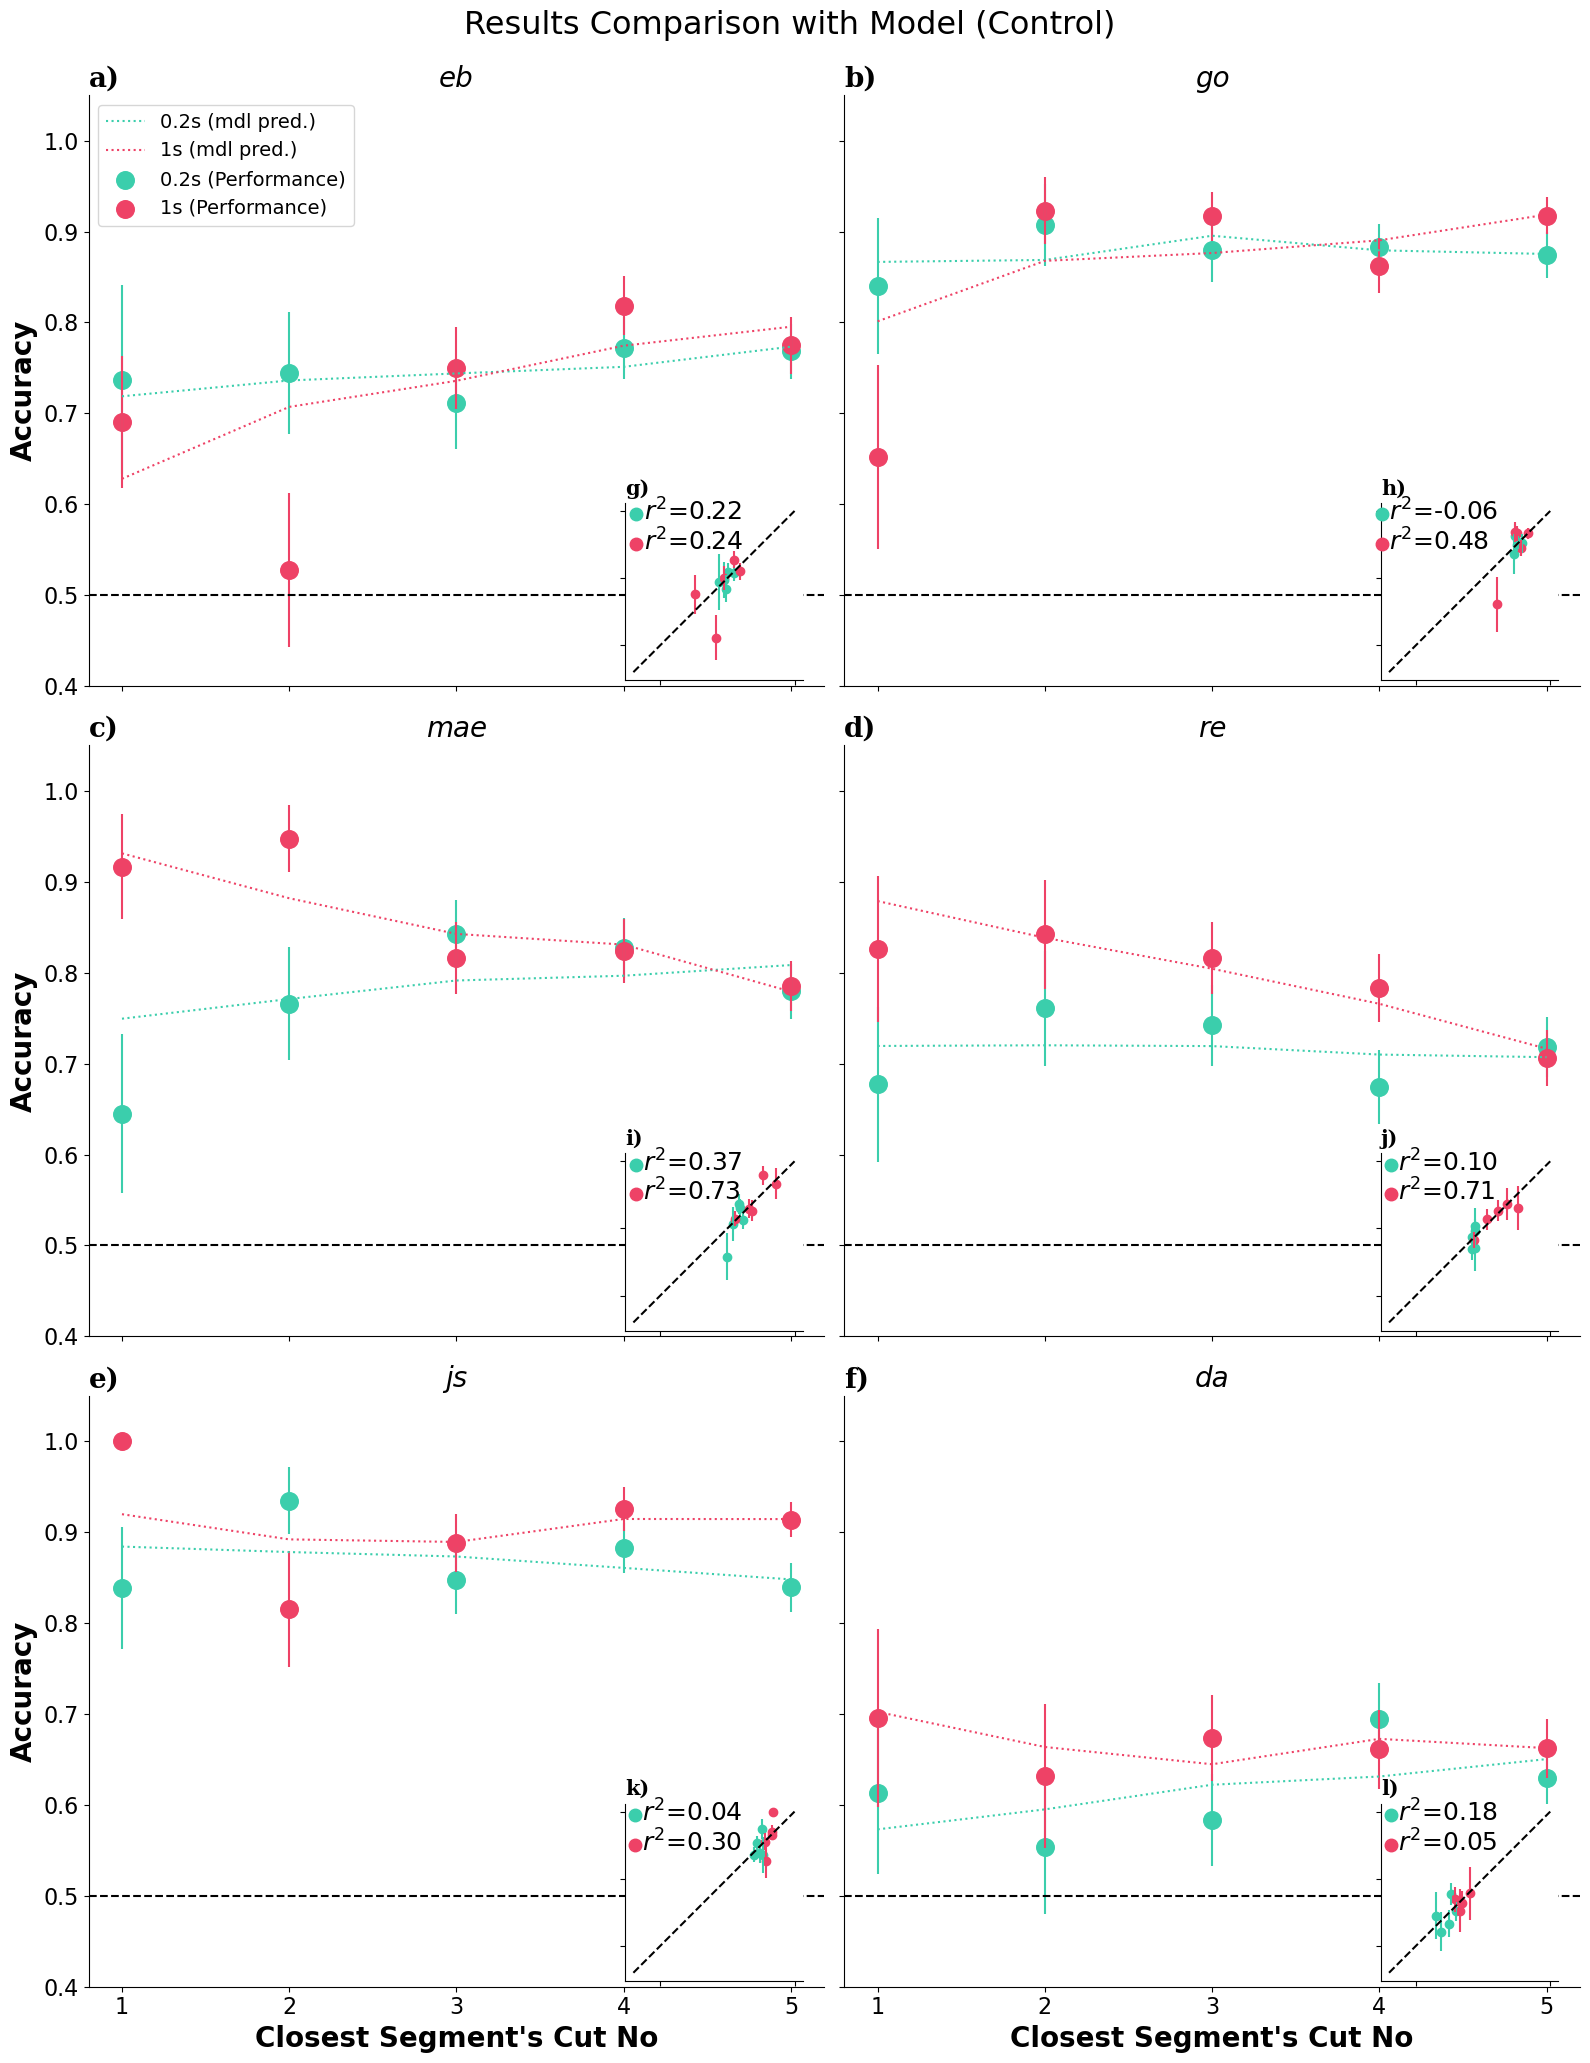

In [8]:
plotTitles = ['a)', 'b)', 'c)', 'd)', 'e)','f)']
subplotTitles = ['g)', 'h)', 'i)', 'j)', 'k)','l)']

cntrl = 1
comp_model = 'pHat_seg'


fig, axes = plt.subplots(3,2, figsize = (16,21), sharex=True, sharey=True)
axes = axes.ravel()


for i in range(len(allParticipants)):
        
    participantId = allParticipants[i]
    
    error = df.groupby(['participantID','closestSeg','expTime','control'],as_index=False)['correct'].sem()
    error_short = error.loc[(error['expTime'] == 0.2) & (error['control'] == cntrl) & (error['participantID'] == participantId), 'correct']
    error_long =  error.loc[(error['expTime'] == 1) & (error['control'] == cntrl) & (error['participantID'] == participantId), 'correct']

    y_mean = df.groupby(['participantID','closestSeg','expTime','control'],as_index=False)['correct'].mean()
    y_mean_short = y_mean.loc[(y_mean['expTime'] == 0.2) & (y_mean['control'] == cntrl) & (y_mean['participantID'] == participantId),'correct']
    y_mean_long = y_mean.loc[(y_mean['expTime'] == 1) & (y_mean['control'] == cntrl) & (y_mean['participantID'] == participantId),'correct']


    y_model_mean = df.groupby(['participantID','closestSeg','expTime','control'],as_index=False)[comp_model].mean()
    y_model_short = y_model_mean.loc[(y_model_mean['expTime'] == 0.2) & (y_model_mean['control'] == cntrl)& (y_model_mean['participantID'] == participantId) ,comp_model]
    y_model_long = y_model_mean.loc[(y_model_mean['expTime'] == 1) & (y_model_mean['control'] == cntrl) & (y_model_mean['participantID'] == participantId), comp_model]


    ## Compute R^2
    short_r2 = r_2(y_mean_short, y_model_short)
    long_r2 = r_2(y_mean_long, y_model_long)

    x = np.arange(1,6)

    axes[i].errorbar(x, y_mean_short, yerr = error_short, fmt = 'none', c = colorShort)
    axes[i].scatter(x, y_mean_short, label = '0.2s (Performance)', s = dotSize ,c = colorShort)
    #axes[i].set_xlabel('cut no')
    #axes[i].set_ylabel('Accuracy')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    axes[i].errorbar(x, y_mean_long, yerr = error_long, fmt = 'none', c = colorLong)
    axes[i].scatter(x, y_mean_long, label = '1s (Performance)', s = dotSize, c = colorLong)    
    #axes[i].set_ylabel('Accuracy')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    axes[i].plot(x, y_model_short, linestyle='dotted', label = '0.2s (mdl pred.)', c = colorShort)
    axes[i].plot(x, y_model_long, linestyle='dotted', label = '1s (mdl pred.)', c = colorLong)


    axes[i].set_xticks(np.arange(1,6))
    axes[i].axhline(0.5,ls = '--', color = 'k')    
    
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    #axes[i].set_title('{}'.format(participantId), fontsize = 15, fontweight="bold")
    axes[i].set_title('{}'.format(participantId), fontsize = fontSizeTitle, style = 'italic')
    axes[i].set_title(plotTitles[i], fontfamily='serif', loc='left', fontsize = fontSizeTitle, fontweight = 'bold')
    axes[i].set_ylim(bottom = 0.4, top = 1.05)



    ## Add r^2 plots
    # Add small plots        
    error = df.groupby(['participantID','closestSeg','expTime','control'],as_index=False)['correct'].sem()
    error_short = error.loc[(error['expTime'] == 0.2) & (error['control'] == cntrl) & (error['participantID'] == participantId), 'correct']
    error_long =  error.loc[(error['expTime'] == 1) & (error['control'] == cntrl) & (error['participantID'] == participantId), 'correct']

    y_mean = df.groupby(['participantID','closestSeg','expTime','control'],as_index=False)['correct'].mean()
    y_mean_short = y_mean.loc[(y_mean['expTime'] == 0.2) & (y_mean['control'] == cntrl) & (y_mean['participantID'] == participantId),'correct']
    y_mean_long = y_mean.loc[(y_mean['expTime'] == 1) & (y_mean['control'] == cntrl) & (y_mean['participantID'] == participantId),'correct']


    y_model_mean = df.groupby(['participantID','closestSeg','expTime','control'],as_index=False)[comp_model].mean()
    y_model_short = y_model_mean.loc[(y_model_mean['expTime'] == 0.2) & (y_model_mean['control'] == cntrl)& (y_model_mean['participantID'] == participantId) ,comp_model]
    y_model_long = y_model_mean.loc[(y_model_mean['expTime'] == 1) & (y_model_mean['control'] == cntrl) & (y_model_mean['participantID'] == participantId),comp_model]
    

    ident = [0.4, 1.0]
    
    # this is an inset axes over the main axes
    inset = axes[i].inset_axes([0.7,0.01,.3,.3])

    inset.errorbar(y_model_short, y_mean_short, yerr = error_short, fmt = 'none', c = colorShort)
    inset.scatter(y_model_short, y_mean_short, label=r'$r^2$={:.2f}'.format(short_r2), c = colorShort)    
    inset.spines['top'].set_visible(False)
    inset.spines['right'].set_visible(False)

    inset.errorbar(y_model_long, y_mean_long, yerr = error_long, fmt = 'none', c = colorLong)
    inset.scatter(y_model_long, y_mean_long, label=r'$r^2$={:.2f}'.format(long_r2), c = colorLong) 
    inset.spines['top'].set_visible(False)
    inset.spines['right'].set_visible(False)

    inset.tick_params(axis='both', which='major', labelsize=18)
    inset.plot(ident,ident, 'k--')
    inset.set_yticklabels([])
    inset.set_xticklabels([])    
    #inset.legend(fontsize = 'x-small', loc = 'lower right', bbox_to_anchor=(3.5, 2.1), frameon = True, columnspacing = 1)
    inset.set_title(subplotTitles[i], fontfamily='serif', loc='left',fontsize = 15, fontweight = 'bold' )
    #inset.set_title('{}'.format(participantId), fontsize = 15, fontweight='bold' )
    inset.set_aspect('equal', adjustable='box')
    inset.legend(loc = 'upper right', bbox_to_anchor=(0.79, 1.15), frameon = False, handletextpad = -0.7, fontsize = 18, labelspacing = 0.1, markerscale = 1.5)
           

axes[0].set_ylabel('Accuracy', fontsize=20,fontweight='bold' )
axes[2].set_ylabel('Accuracy', fontsize=20, fontweight='bold' )
axes[4].set_ylabel('Accuracy', fontsize=20, fontweight='bold' )
axes[4].set_xlabel('Closest Segment\'s Cut No', fontsize=20, fontweight='bold' )
axes[5].set_xlabel('Closest Segment\'s Cut No', fontsize=20, fontweight='bold' )
axes[0].legend(loc = 'upper left', title_fontsize='large', prop={'size':14})

#fig.suptitle('Results Comparison with Model (Test) \n' + r'$\it{glm(correct \sim cut No * Exposure Time)}$', fontsize = 15)
fig.suptitle('Results Comparison with Model (Control) \n', fontsize = 23)
plt.tight_layout()

figname = 'figs/thesis/'+'cntrl_all.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)


# Plot Coefficients

## Separate GLMs

In [9]:
path ='data/test_all_coeffs.csv'
coeffs_test = pd.read_csv(path)
coeffs_test['error'] = (coeffs_test['ub'] - coeffs_test['lb'])/2


path ='data/cntrl_all_coeffs_closeSeg.csv'
coeffs_cntrl = pd.read_csv(path)
coeffs_cntrl['error'] = (coeffs_cntrl['ub'] - coeffs_cntrl['lb'])/2

subjects = coeffs_test.id.unique()
subjects = np.sort(subjects)

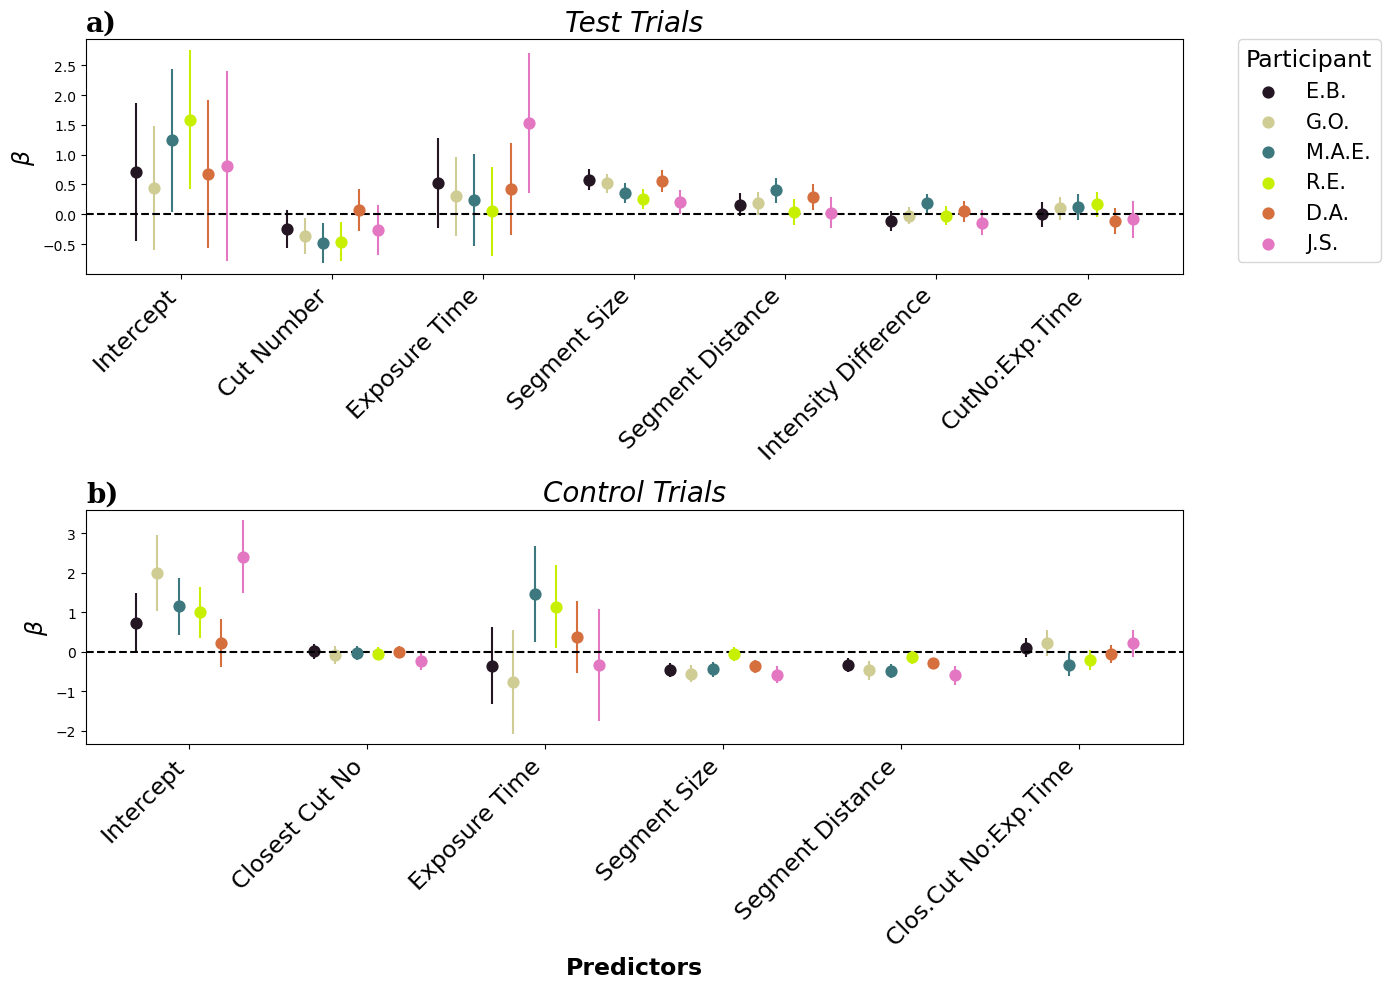

In [10]:
fig, ax = plt.subplots(2,1, figsize = (14,10))

# Plot test
xLabels = ['Intercept', 'Cut Number', 'Exposure Time', 'Segment Size', 'Segment Distance', 'Intensity Difference', 'CutNo:Exp.Time']
noPredictors = len(xLabels)
colors = [colorMap['eb']]*noPredictors + [colorMap['go']]*noPredictors + [colorMap['mae']]*noPredictors + [colorMap['re']]*noPredictors + [colorMap['da']]*noPredictors + [colorMap['js']]*noPredictors 

sns.pointplot(data = coeffs_test, x = 'coef_names', y = 'coefs', hue = 'id', palette = colorMap, dodge=0.6, join=False, ax = ax[0])
ax[0].set_xticklabels(xLabels, rotation=45, horizontalalignment='right')
ax[0].axhline(0,ls = '--', color = 'k')    
ax[0].set_ylabel(r'$\beta$', fontsize = 17, fontdict=dict(weight='bold'))
ax[0].set_xlabel('')
ax[0].set_xticklabels(ax[0].get_xmajorticklabels(),fontsize = 17)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax[0].collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

errors = coeffs_test['error']
ax[0].errorbar(x_coords, y_coords, yerr= errors, fmt=' ', zorder=-1,ecolor=colors)
ax[0].get_legend().remove()
ax[0].set_title('a)', fontfamily='serif', loc='left', fontsize=fontSizeTitle, fontweight = 'bold')
ax[0].set_title('Test Trials', style = 'italic', fontsize = fontSizeTitle)

legHandles = ax[0].get_legend_handles_labels()[0]
leg = ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': 15}, fontsize='small', handles = legHandles, labels = legendLabels)

leg.set_title('Participant',prop={'size':fontSizeLegend})

# Plot control
xLabels = ['Intercept', 'Closest Cut No', 'Exposure Time', 'Segment Size', 'Segment Distance', 'Clos.Cut No:Exp.Time']

noPredictors = len(xLabels)
colors = [colorMap['eb']]*noPredictors + [colorMap['go']]*noPredictors + [colorMap['mae']]*noPredictors + [colorMap['re']]*noPredictors + [colorMap['da']]*noPredictors + [colorMap['js']]*noPredictors 

sns.pointplot(data = coeffs_cntrl, x = 'coef_names', y = 'coefs', hue = 'id', palette = colorMap, dodge=0.6, join=False, ax = ax[1], legend = None)
ax[1].set_xticklabels(xLabels, rotation=45, horizontalalignment='right')
ax[1].axhline(0,ls = '--', color = 'k')    
ax[1].set_ylabel(r'$\beta$', fontsize = 17, fontdict=dict(weight='bold'))
ax[1].set_xlabel('Predictors', fontsize = 17, fontdict=dict(weight='bold'))
ax[1].set_title('Control Trials', style = 'italic', fontsize = fontSizeTitle)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax[1].collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

errors = coeffs_cntrl['error']

ax[1].errorbar(x_coords, y_coords, yerr= errors, fmt=' ', zorder=-1,ecolor=colors)
ax[1].set_title('b)', fontfamily='serif', loc='left', fontsize=fontSizeTitle, fontweight = 'bold')
ax[1].set_xticklabels(ax[1].get_xmajorticklabels(),fontsize = 17)

leg = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': fontSizeLegend}, fontsize=13)
leg.remove()

plt.tight_layout()

figname = 'figs/thesis/'+'coefficients_combined.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)


### With block no for learning

In [11]:
path ='data/learning/test_all_coeffs_learn.csv'
coeffs_test = pd.read_csv(path)
coeffs_test['error'] = (coeffs_test['ub'] - coeffs_test['lb'])/2


path ='data/learning/cntrl_all_coeffs_closeSeg_learning.csv'
coeffs_cntrl = pd.read_csv(path)
coeffs_cntrl['error'] = (coeffs_cntrl['ub'] - coeffs_cntrl['lb'])/2

subjects = coeffs_test.id.unique()
subjects = np.sort(subjects)

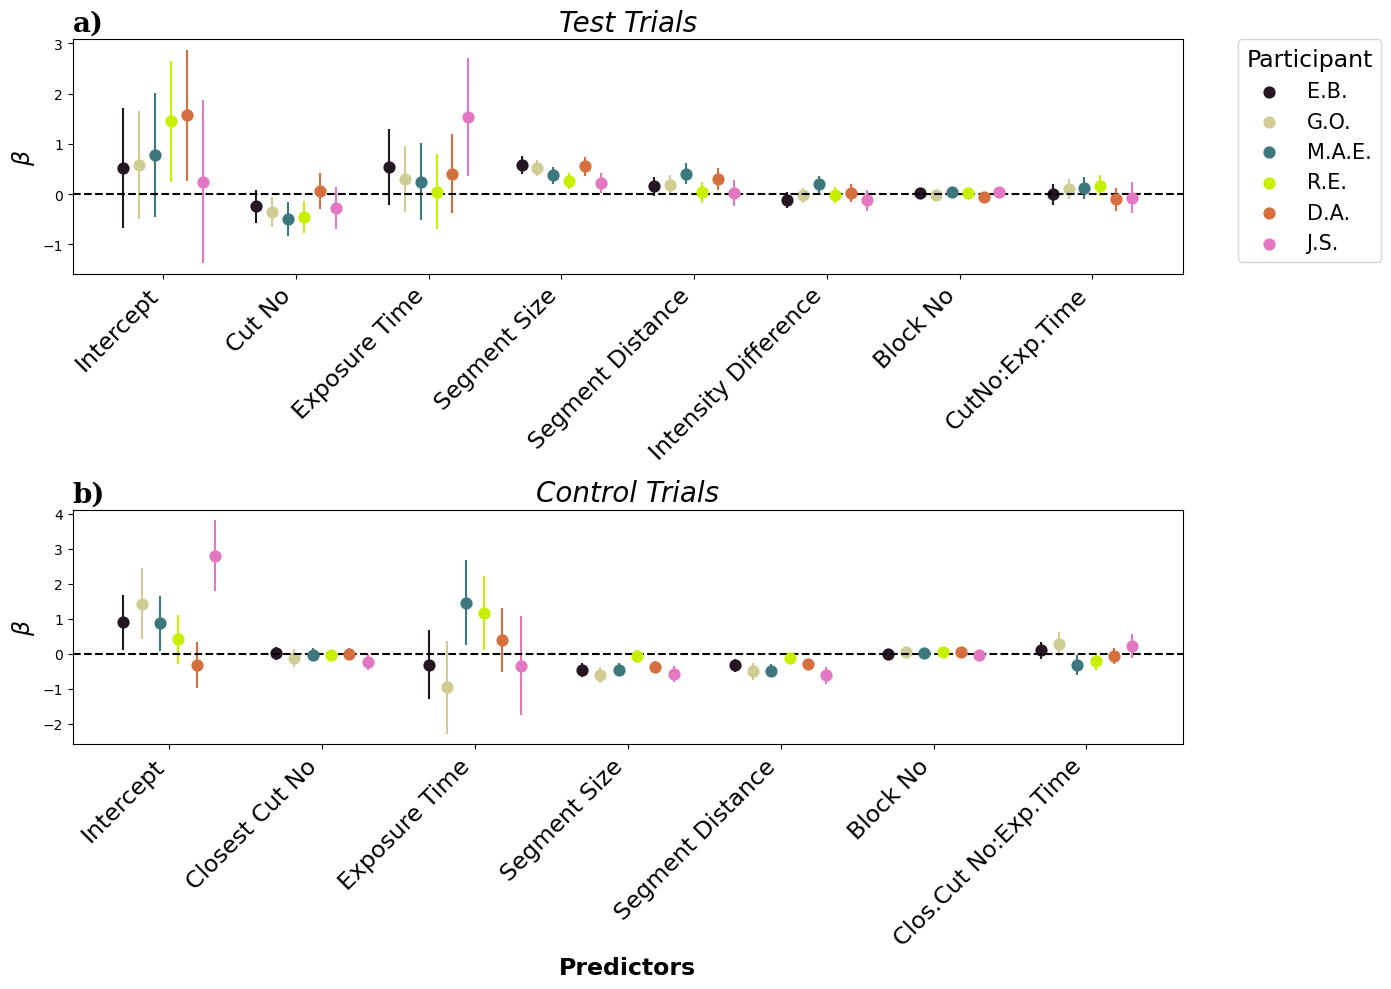

In [12]:
fig, ax = plt.subplots(2,1, figsize = (14,10))

# Plot test
xLabels = ['Intercept', 'Cut No', 'Exposure Time', 'Segment Size', 'Segment Distance', 'Intensity Difference', 'Block No', 'CutNo:Exp.Time']
noPredictors = len(xLabels)
colors = [colorMap['eb']]*noPredictors + [colorMap['go']]*noPredictors + [colorMap['mae']]*noPredictors + [colorMap['re']]*noPredictors + [colorMap['da']]*noPredictors + [colorMap['js']]*noPredictors 

sns.pointplot(data = coeffs_test, x = 'coef_names', y = 'coefs', hue = 'id', palette = colorMap, dodge=0.6, join=False, ax = ax[0])
ax[0].set_xticklabels(xLabels, rotation=45, horizontalalignment='right')
ax[0].axhline(0,ls = '--', color = 'k')    
ax[0].set_ylabel(r'$\beta$', fontsize = 17, fontweight='bold')
ax[0].set_xlabel('')
ax[0].set_xticklabels(ax[0].get_xmajorticklabels(),fontsize = 17)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax[0].collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

errors = coeffs_test['error']
ax[0].errorbar(x_coords, y_coords, yerr= errors, fmt=' ', zorder=-1,ecolor=colors)
ax[0].get_legend().remove()
ax[0].set_title('a)', fontfamily='serif', loc='left', fontsize=fontSizeTitle, fontweight = 'bold')
ax[0].set_title('Test Trials', style = 'italic', fontsize = fontSizeTitle)

legHandles = ax[0].get_legend_handles_labels()[0]
leg = ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': 15}, fontsize='small', handles = legHandles, labels = legendLabels)

leg.set_title('Participant',prop={'size':fontSizeLegend})

# Plot control
xLabels = ['Intercept', 'Closest Cut No', 'Exposure Time', 'Segment Size', 'Segment Distance', 'Block No', 'Clos.Cut No:Exp.Time']

noPredictors = len(xLabels)
colors = [colorMap['eb']]*noPredictors + [colorMap['go']]*noPredictors + [colorMap['mae']]*noPredictors + [colorMap['re']]*noPredictors + [colorMap['da']]*noPredictors + [colorMap['js']]*noPredictors 

sns.pointplot(data = coeffs_cntrl, x = 'coef_names', y = 'coefs', hue = 'id', palette = colorMap, dodge=0.6, join=False, ax = ax[1], legend = None)
ax[1].set_xticklabels(xLabels, rotation=45, horizontalalignment='right')
ax[1].axhline(0,ls = '--', color = 'k')    
ax[1].set_ylabel(r'$\beta$', fontsize = 17, fontweight='bold')
ax[1].set_xlabel('Predictors', fontsize = 17, fontweight='bold')
ax[1].set_title('Control Trials', style = 'italic', fontsize = fontSizeTitle)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax[1].collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

errors = coeffs_cntrl['error']

ax[1].errorbar(x_coords, y_coords, yerr= errors, fmt=' ', zorder=-1,ecolor=colors)
ax[1].set_title('b)', fontfamily='serif', loc='left', fontsize=fontSizeTitle, fontweight = 'bold')
ax[1].set_xticklabels(ax[1].get_xmajorticklabels(),fontsize = 17)

leg = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': 16}, fontsize='small')
leg.remove()

plt.tight_layout()

figname = 'figs/thesis/'+'coefficients_combined.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)


## Random Intercept Model

In [13]:
path ='data/rndm_int_test_cutNo.csv'
rndInt_test_cutNo = pd.read_csv(path)
rndInt_test_cutNo['error'] = (rndInt_test_cutNo['ub'] - rndInt_test_cutNo['lb'])/2

path ='data/rndm_int_test_cumEff.csv'
rndInt_test_cumEff = pd.read_csv(path)
rndInt_test_cumEff['error'] = (rndInt_test_cumEff['ub'] - rndInt_test_cumEff['lb'])/2

path ='data/rndm_int_cntrl.csv'
rndInt_cntrl = pd.read_csv(path)
rndInt_cntrl['error'] = (rndInt_cntrl['ub'] - rndInt_cntrl['lb'])/2

/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_85160/2755669232.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(xLabels, rotation=45, horizontalalignment='right')
/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_85160/2755669232.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xmajorticklabels(),fontsize = 17)
/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_85160/2755669232.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xLabels, rotation=45, horizontalalignment='right')
/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_85160/2755669232.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xmajorticklabels(),fontsize = 17)


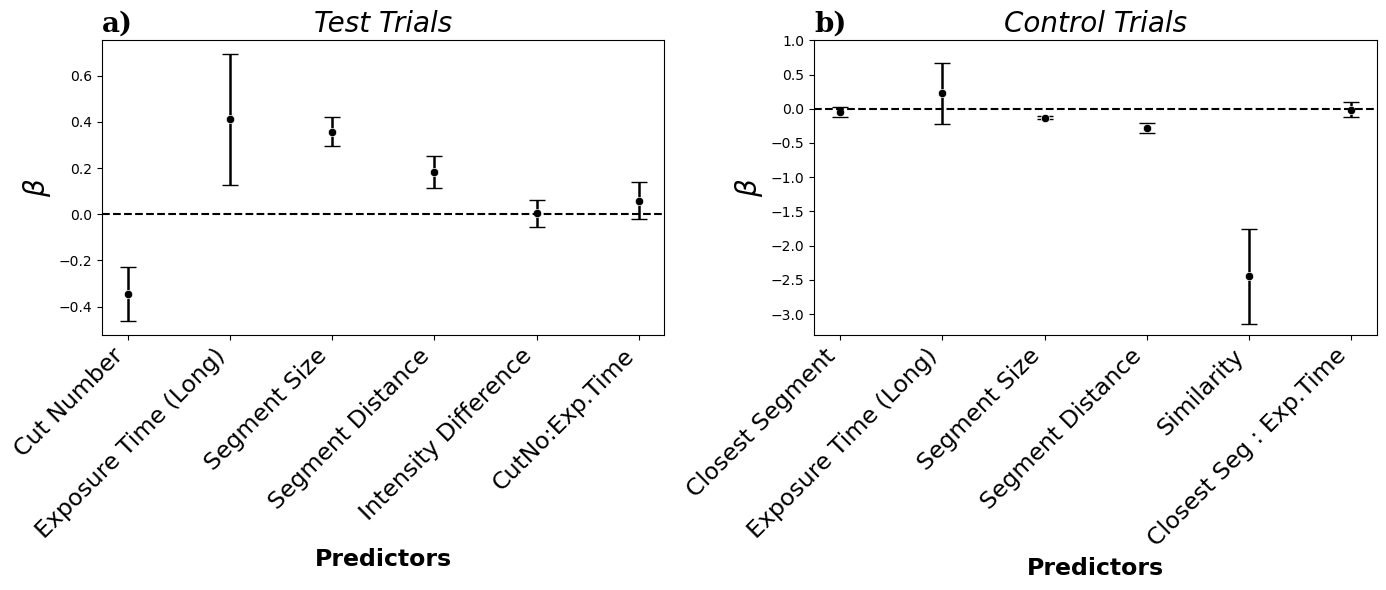

In [14]:
color = 'k'

fig, ax = plt.subplots(1,2, figsize = (14,6))

# Plot test
xLabels = ['Cut Number', 'Exposure Time (Long)', 'Segment Size', 'Segment Distance', 'Intensity Difference', 'CutNo:Exp.Time']
noPredictors = len(xLabels)
colors = ['tab:olive']*noPredictors + ['tab:cyan']*noPredictors + ['tab:red']*noPredictors + ['tab:grey']*noPredictors + ['brown']*noPredictors + ['tab:pink']*noPredictors 

sns.scatterplot(data = rndInt_test_cutNo[1::], x = 'coef_names', y = 'coefs', ax = ax[0],  color = color)
ax[0].set_xticklabels(xLabels, rotation=45, horizontalalignment='right')
ax[0].axhline(0,ls = '--', color = 'k')    
ax[0].set_ylabel(r'$\beta$', fontsize = 20, fontdict=dict(weight='bold'))
ax[0].set_xlabel('Predictors', fontsize = 17, fontdict=dict(weight='bold'))
ax[0].set_xticklabels(ax[0].get_xmajorticklabels(),fontsize = 17)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax[0].collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

errors = rndInt_test_cutNo['error'][1::]
ax[0].errorbar(x_coords, y_coords, yerr= errors, capsize = 5.5, elinewidth = 1.8, fmt=' ', zorder=-1, color = color)
ax[0].set_title('Test Trials', style = 'italic', fontsize = fontSizeTitle)
ax[0].set_title('a)', fontfamily='serif', loc='left', fontsize=fontSizeTitle, fontweight = 'bold')

# Plot control
xLabels = ['Closest Segment', 'Exposure Time (Long)', 'Segment Size', 'Segment Distance', 'Similarity', 'Closest Seg : Exp.Time']
noPredictors = len(xLabels)
colors = ['tab:olive']*noPredictors + ['tab:cyan']*noPredictors + ['tab:red']*noPredictors + ['tab:grey']*noPredictors + ['brown']*noPredictors + ['tab:pink']*noPredictors 

sns.scatterplot(data = rndInt_cntrl[1::], x = 'coef_names', y = 'coefs', ax = ax[1],  color = color)
ax[1].set_xticklabels(xLabels, rotation=45, horizontalalignment='right')
ax[1].axhline(0,ls = '--', color = 'k')    
ax[1].set_ylabel(r'$\beta$', fontsize = 20, fontdict=dict(weight='bold'))
ax[1].set_xlabel('Predictors', fontsize = fontSizeLabel, fontdict=dict(weight='bold'))
ax[1].set_ylim(bottom=-3.3, top = 1)
ax[1].set_xticklabels(ax[1].get_xmajorticklabels(),fontsize = 17)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax[1].collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

errors = rndInt_cntrl['error'][1::]
ax[1].errorbar(x_coords, y_coords, yerr= errors, capsize = 5.5, elinewidth = 1.8, fmt=' ', zorder=-1,  color = color)
ax[1].set_title('Control Trials', style = 'italic', fontsize = fontSizeTitle)
ax[1].set_title('b)', fontfamily='serif', loc='left', fontsize=fontSizeTitle, fontweight = 'bold')

plt.tight_layout()

figname = 'figs/thesis/' +'coefficients_rndInt.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

# Plot Anovas

In [15]:
participantId = 'eb'
anovaName = '_anova.csv'
path ='data/' + participantId + '/'
eb_anova = pd.read_csv(path + participantId + anovaName)

participantId = 'go'
path ='data/' + participantId + '/'
go_anova = pd.read_csv(path + participantId + anovaName)

participantId = 'mae'
path ='data/' + participantId + '/'
mae_anova = pd.read_csv(path + participantId + anovaName)

participantId = 're'
path ='data/' + participantId + '/'
re_anova = pd.read_csv(path + participantId + anovaName)

participantId = 'da'
path ='data/' + participantId + '/'
da_anova = pd.read_csv(path + participantId + anovaName)

participantId = 'js'
path ='data/' + participantId + '/'
js_anova = pd.read_csv(path + participantId + anovaName)


anova = pd.concat([eb_anova, go_anova, mae_anova, re_anova, da_anova, js_anova])

anova['significant'] = False
anova.loc[anova['Pr..Chi.'] < 0.05, 'significant'] = True

In [16]:
## Plotting Settings
sns.set(font_scale = 1.5, style="white")

markers = {True:"d",
           False:"o"}

colorMap = {"eb": '#241623',
         "go": '#D0CD94',
         "mae":'#3C787E',
         "re": '#C7EF00',
         "da": '#D56F3E',
         "js": 'tab:pink'
        }

legendLabels = ['E.B.', 'G.O.', 'M.A.E.', 'R.E.','D.A.','J.S.']


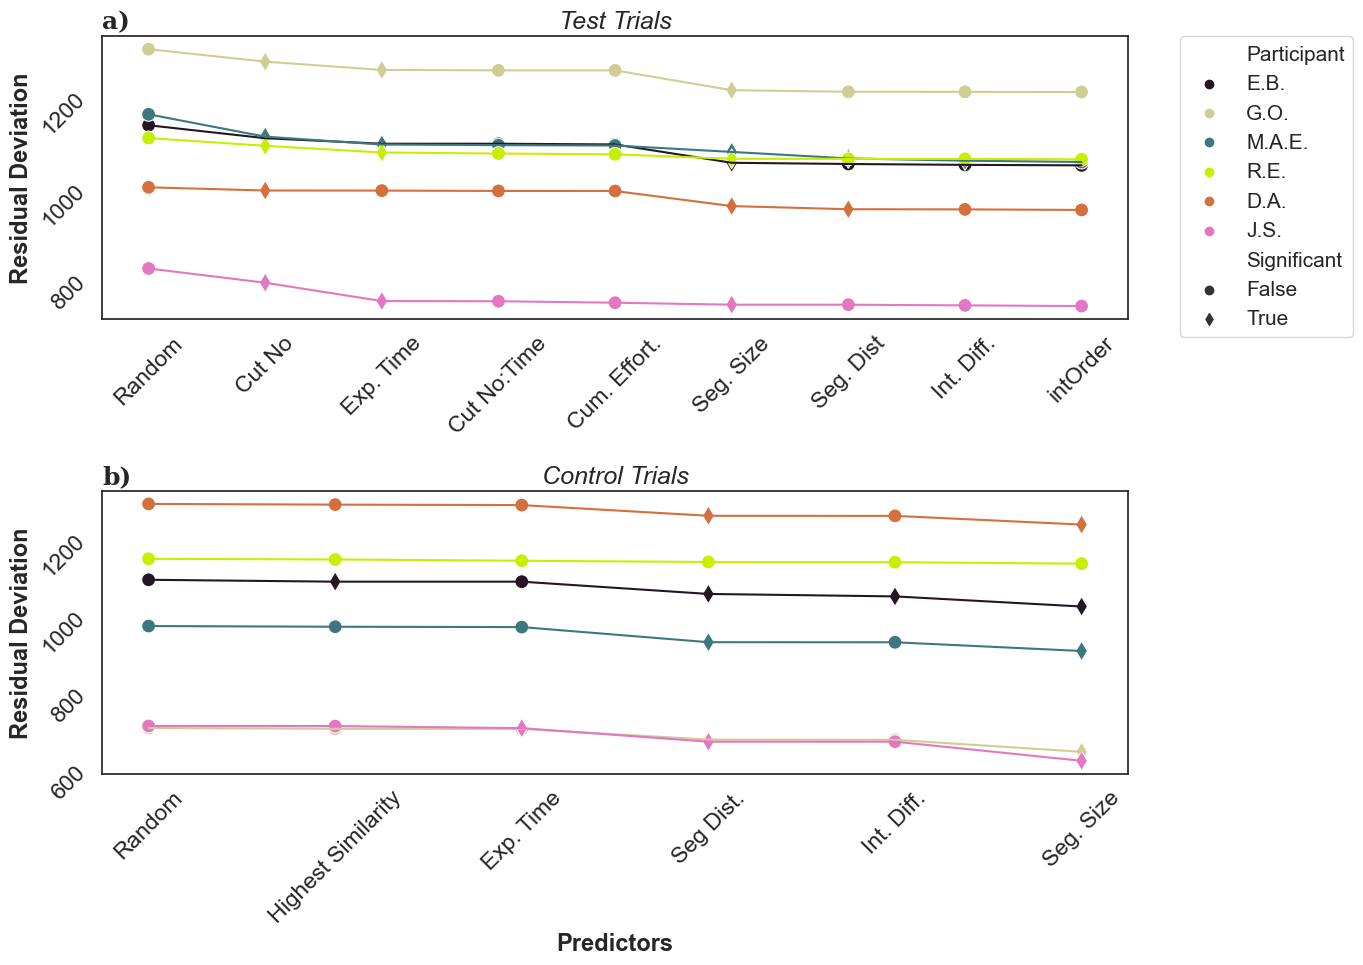

In [17]:
fig, ax = plt.subplots(2,1, figsize = (14,10))

anova = anova.rename(columns={'id':'Participant', 'significant':'Significant'})

# Plot ANOVA table for test 
model = 'cutNo'
sns.scatterplot(data = anova[anova['model'] == model], x = 'predictor', y = 'Resid..Dev', style = 'Significant',markers = markers, s = 100, hue = 'Participant', palette = colorMap, ax=ax[0])
sns.lineplot(data = anova[anova['model'] == model], x = 'predictor', y = 'Resid..Dev', hue = 'Participant', palette = colorMap, ci= None, legend=False, ax = ax[0])
#plt.xticks(rotation=45, ha='right')
ax[0].set_ylabel('Residual Deviation', fontsize = 17, fontweight='bold')
ax[0].tick_params(labelrotation=45) 
ax[0].set_title('Test Trials', style ='italic')
ax[0].set_xlabel('')   
ax[0].set_title('a)', fontfamily='serif', loc='left', fontsize='medium', fontweight = 'bold')


legHandles = ax[0].get_legend_handles_labels()[0]
newLegLabels = ax[0].get_legend_handles_labels()[1]
newLegLabels[1:-3] = legendLabels
leg = ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': 15}, fontsize='small', handles = legHandles, labels = newLegLabels)
#leg.set_title('Participant',prop={'size':'large'})
#leg.set_title('Participant',prop={'size':fontSizeLegend})


# Plot ANOVA table for control
model = 'similarity'
sns.scatterplot(data = anova[anova['model'] == model], x = 'predictor', y = 'Resid..Dev', style = 'Significant',markers = markers, s = 100, hue = 'Participant', palette = colorMap, legend=False, ax = ax[1])
sns.lineplot(data = anova[anova['model'] == model], x = 'predictor', y = 'Resid..Dev', hue = 'Participant', palette = colorMap, ci= None, legend=False,  ax = ax[1])
#ax[0].set_xticks(rotation=45, ha='right')
ax[1].set_ylabel('Residual Deviation', fontsize = 17, fontweight='bold')
ax[1].set_xlabel('Predictors', fontsize = 17, fontweight='bold')
ax[1].tick_params(labelrotation=45) 
ax[1].set_title('Control Trials', style ='italic')
ax[1].set_title('b)', fontfamily='serif', loc='left', fontsize='medium', fontweight = 'bold')

plt.tight_layout()

figname = 'figs/thesis/' +'anova_combined.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

# Plot Psychophysics

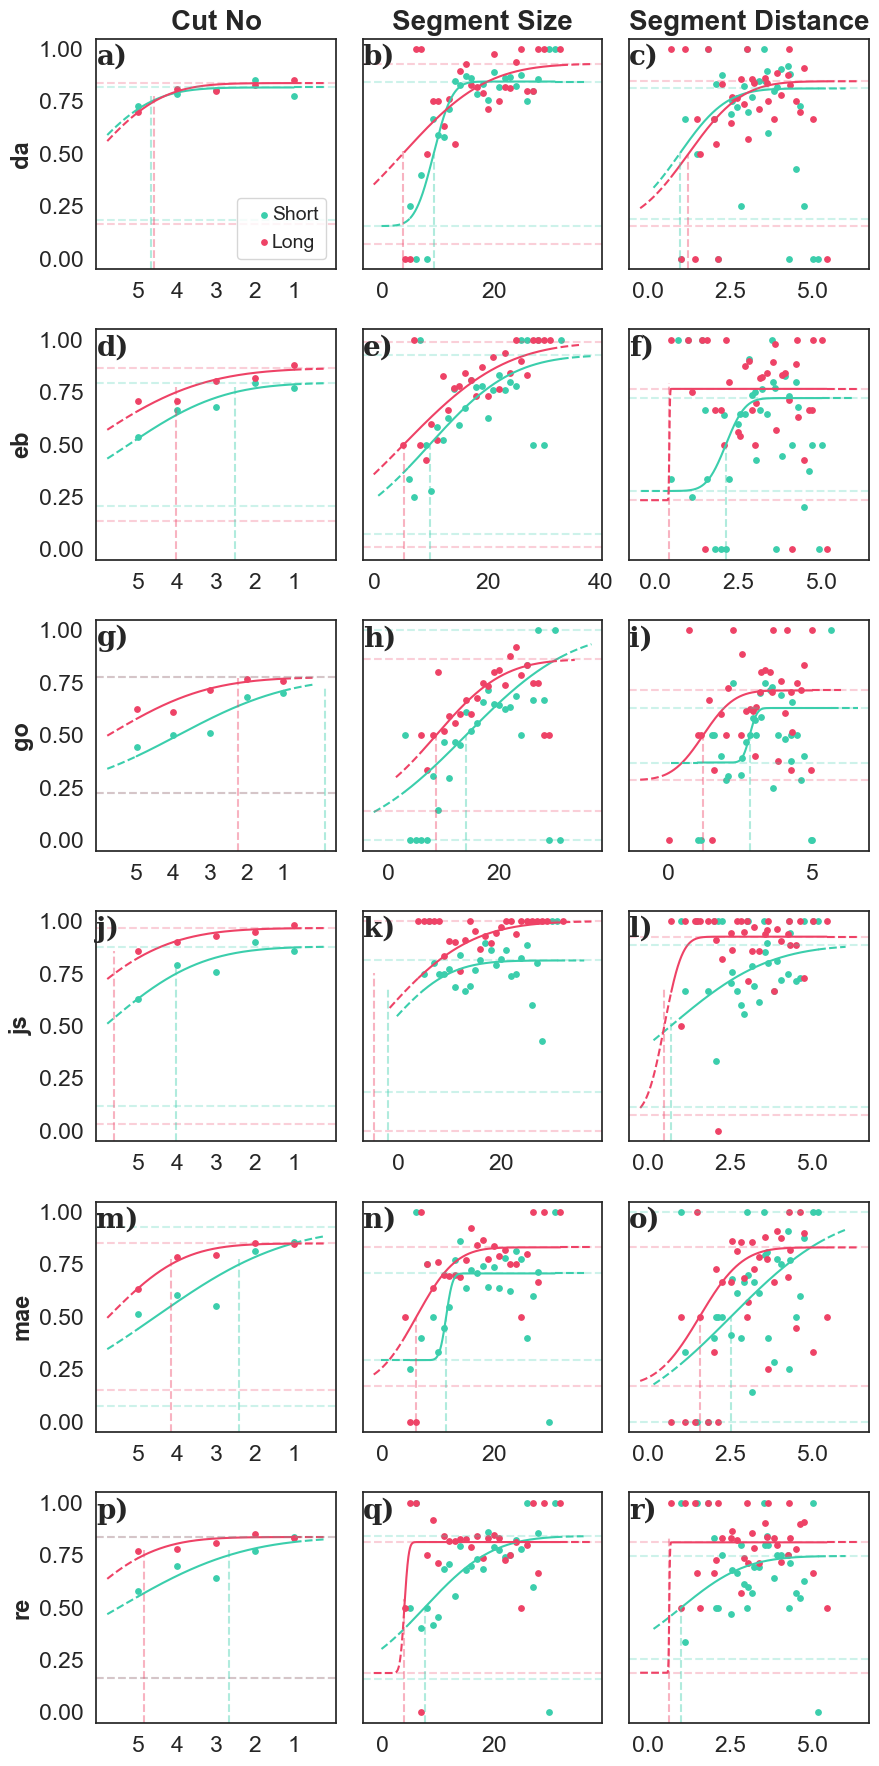

In [42]:

preds = ['cutNo', 'segSize', 'segDist']
predNames =  ['Cut No', 'Segment Size', 'Segment Distance']

participants = ['da', 'eb', 'go', 'js', 'mae', 're']
idNum = len(participants)

fig, axes = plt.subplots(idNum,3, figsize = (9,18), sharey=True)
axesIDs = axes.ravel()

chrList = [chr(i) for i in range(ord('a'),ord('a') + (idNum*3))]

for j in range(len(preds)):
    pred = preds[j]
    mat_fname = 'data/psych_' + pred + '.mat'
    container = sio.loadmat(mat_fname)

    for i in range(idNum):
        id = participants[i]
        
        # Plot curves
        axes[i,j].plot(container['plotData'][0][i]['shortXplt'][0], container['plotData'][0][i]['shortYplt'][0], color = colorShort) # short
        axes[i,j].plot(container['plotData'][0][i]['longXplt'][0], container['plotData'][0][i]['longYplt'][0], color = colorLong) # long 
        
        axes[i,j].plot(container['plotData'][0][i]['dshd1shortX'][0], container['plotData'][0][i]['dshd1shortY'][0], color = colorShort, linestyle = '--') # short
        axes[i,j].plot(container['plotData'][0][i]['dshd1longX'][0], container['plotData'][0][i]['dshd1longY'][0], color = colorLong, linestyle = '--') # long 

        axes[i,j].plot(container['plotData'][0][i]['dshd2shortX'][0], container['plotData'][0][i]['dshd2shortY'][0], color = colorShort, linestyle = '--') # short
        axes[i,j].plot(container['plotData'][0][i]['dshd2longX'][0], container['plotData'][0][i]['dshd2longY'][0], color = colorLong, linestyle = '--') # long 
            

        # Plot lower asymptotes
        axes[i,j].axhline(container['plotData'][0][i]['asymp1shortY'][0,0],ls = '--', color = colorShort, alpha = 0.25)    
        axes[i,j].axhline(container['plotData'][0][i]['asymp1longY'][0,0],ls = '--', color = colorLong, alpha = 0.25)    

        # Plot lower asymptotes
        axes[i,j].axhline(container['plotData'][0][i]['asymp2shortY'][0,0],ls = '--', color = colorShort, alpha = 0.25)    
        axes[i,j].axhline(container['plotData'][0][i]['asymp2longY'][0,0],ls = '--', color = colorLong, alpha = 0.25)    
        

        # Plot data
        axes[i,j].scatter(container['plotData'][0][i]['shortXdata'][0], container['plotData'][0][i]['shortYdata'][0], color = colorShort, s = 15, label = 'Short') # short
        axes[i,j].scatter(container['plotData'][0][i]['longX'][0], container['plotData'][0][i]['longY'][0], color = colorLong, s = 15, label = 'Long') # long 

        # Plot thresholds
        y_lim_id = find_closest_number(container['plotData'][0][i]['shortXplt'][0], container['plotData'][0][i]['thrShort'][0,0])
        y_lim = container['plotData'][0][i]['shortYplt'][0,y_lim_id]
        axes[i,j].axvline(x=container['plotData'][0][i]['thrShort'][0],ymax=y_lim, linestyle='--', color = colorShort, alpha = 0.4) # short

        y_lim_id = find_closest_number(container['plotData'][0][i]['longXplt'][0], container['plotData'][0][i]['thrLong'][0,0])
        y_lim = container['plotData'][0][i]['longYplt'][0,y_lim_id]
        axes[i,j].axvline(x=container['plotData'][0][i]['thrLong'][0], ymax=y_lim, linestyle='--', color = colorLong, alpha = 0.4) # long
        
        axes[0,j].set_title('{}'.format(predNames[j]),fontsize = fontSizeTitle, fontweight="bold")
        axes[i,0].set_ylabel('{}'.format(id), fontsize = fontSizeLabel, fontweight="bold")        
        
        pltNo = [i for i in range(i*3,(i*3)+3)][j]
        axes[i,j].set_title(chrList[pltNo] + ')', fontfamily='serif', loc='left', fontsize=fontSizeTitle, fontweight = 'bold', y = 0.85)

        #axes[i,j].set_xticks(axes[i,j].get_xticks())                

        if pred == 'cutNo':
           axes[i,j].set_xticks(np.arange(1,6))
           axes[i,j].set_xticklabels((np.flip(axes[i,j].get_xticks()).astype(int)));                  

        #axes[i,j].set_aspect('equal', adjustable='box')
#fig.suptitle("Psychometric Function Fits \n", fontsize = 16)
axes[0,0].legend(loc = 'lower right', title_fontsize='large', prop={'size':14}, handletextpad = -0.6)
plt.tight_layout()

figname = 'figs/thesis/psych_fits.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

## Plotting Marginal Densities with Sampling Results

In [7]:
file_pth ='data/sampling.pkl'
sampleDf = pd.read_pickle(file_pth)

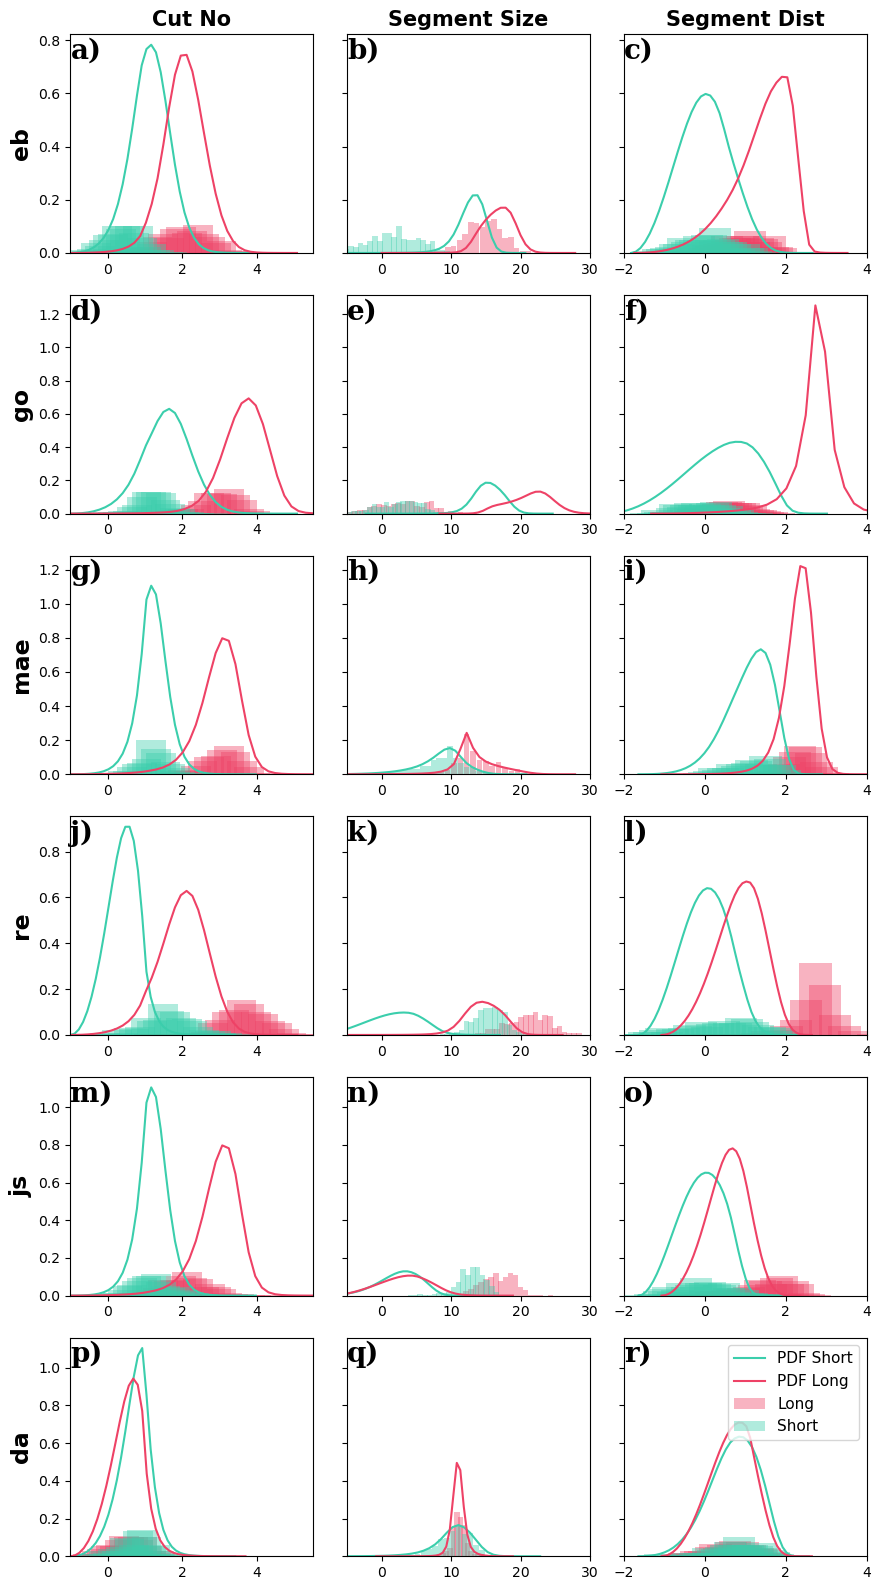

In [8]:
preds = ['cutNo', 'segSize', 'segDist']
predTitles = ['Cut No', 'Segment Size', 'Segment Dist']

chrList = [chr(i) for i in range(ord('a'),ord('a') + (len(allParticipants)*3))]

fig, axes = plt.subplots(6,3, figsize=(9,16), sharey='row', sharex=False)
for j in range(len(preds)):
    pred = preds[j]       
    predTit = predTitles[j]

    for i in range(len(allParticipants)):
        participantId = allParticipants[i]
        trgt_df = sampleDf.loc[sampleDf['pred'] == pred]
        
        # Plot sampling
        axes[i,j].bar(trgt_df.iloc[i].long_x, trgt_df.iloc[i].long_prob, color=colorLong, alpha = 0.4, label = "Long")
        axes[i,j].bar(trgt_df.iloc[i].short_x, trgt_df.iloc[i].short_prob, color = colorShort, alpha = 0.4, label = "Short")  
        
        # Plot marginal densities
        if pred == 'segDist':
            file_pth ='data/{}/psych_segDist_{}.csv'.format(participantId, participantId)        
        elif pred == 'segSize':
            file_pth ='data/{}/psych_segSize_{}.csv'.format(participantId, participantId)        
        elif pred == 'cutNo':
            file_pth ='data/{}/psych_cutNo_{}.csv'.format(participantId, participantId)     
        
        marginalDensity = pd.read_csv(file_pth, header=None)
        marginalDensity = marginalDensity.rename(columns={0: 'x_short', 1: 'y_short', 2:'x_long', 3:'y_long'})

        axes[i,j].plot(marginalDensity['x_short'], marginalDensity['y_short'], label = 'PDF Short', color=colorShort)
        axes[i,j].plot(marginalDensity['x_long'], marginalDensity['y_long'], label = 'PDF Long', color=colorLong)    

        # t score and p values
        t =  trgt_df.iloc[i].t
        p = trgt_df.iloc[i].p
        
        # Set y label for participants
        axes[i,0].set_ylabel(participantId, fontsize = fontSizeLabel, fontweight="bold")       

        # Set plot titles
        pltNo = [i for i in range(i*3,(i*3)+3)][j]
        axes[i,j].set_title(chrList[pltNo] + ')', fontfamily='serif', loc='left', fontsize=fontSizeTitle, fontweight = 'bold', y = 0.85)

        if j == 0:            
            axes[i,j].set_xlim([-1,5.5])
        elif j == 1:
            axes[i,j].set_xlim([-5,30])
        elif j == 2:
            axes[i,j].set_xlim([-2,4])

    # Set labels
    axes[0,j].set_title(predTit, fontsize = 15, fontweight="bold")    
    
        
axes[-1,-1].legend(loc = 'upper right', title_fontsize='small', prop={'size':11})
plt.tight_layout()

figname = 'figs/thesis/marginalDensities.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

### Compute LogLikelihoods

In [9]:

colnames = ['x', 'da_y_short', 'da_y_long', 'eb_y_short', 'eb_y_long', 'go_y_short', 'go_y_long', 'mae_y_short', 'mae_y_long', 'js_y_short', 'js_y_long', 're_y_short', 're_y_long']
file_pth = 'data/cutNo_psychFit.csv'
cutNoPlt = pd.read_csv(file_pth, header=None).T
cutNoPlt.columns = colnames


colnames = ['da_x', 'da_y_short', 'da_y_long', 'eb_x', 'eb_y_short', 'eb_y_long', 'go_x', 'go_y_short', 'go_y_long', 'mae_x', 'mae_y_short', 'mae_y_long', 'js_x', 'js_y_short', 'js_y_long', 're_x', 're_y_short', 're_y_long']
file_pth = 'data/segDist_psychFit.csv'
segDistPlt = pd.read_csv(file_pth, header=None).T
segDistPlt.columns = colnames

file_pth = 'data/segSize_psychFit.csv'
segSizePlt = pd.read_csv(file_pth, header=None).T
segSizePlt.columns = colnames




In [10]:
participants = ['da', 'eb', 'go', 'mae', 'js', 're']

logLikeSegDist = np.zeros((len(participants),1))

for id in range(len(participants)):
    
    participantId = participants[id]
    trgt_df = df.loc[(df['participantID'] == participantId),:]
    rng = len(trgt_df)

    # Initialize required values
    correct = trgt_df.correct.values
    segDist = trgt_df.segCentDist.values
    expTime = trgt_df.expCond.values

    likelihood = 0
    for i in range(rng):
    
        # retrieve the participant and expTime specific X and Ys
        trgtXid = id*3                

        if expTime[i] == 1:
            trgtYid = trgtXid + 1
        else:
            trgtYid = trgtXid + 2

        X = segDistPlt.iloc[:,trgtXid]    
        Y = segDistPlt.iloc[:,trgtYid]    
        
        # Compute probability        
        idx = find_closest_number(X, segDist[i])
        if correct[i] == 1:
            prob = Y[idx]
        else:
            prob = 1 - Y[idx]

        # Compute total log likelihood
        likelihood = likelihood + np.log(prob)

    logLikeSegDist[id] = likelihood

In [14]:
participants = ['da', 'eb', 'go', 'mae', 'js', 're']

logLikeSegSize = np.zeros((len(participants),1))

for id in range(len(participants)):
    
    participantId = participants[id]
    trgt_df = df.loc[(df['participantID'] == participantId),:]
    rng = len(trgt_df)

    # Initialize required values
    correct = trgt_df.correct.values
    segDist = trgt_df.segSize.values
    expTime = trgt_df.expCond.values

    likelihood = 0
    for i in range(rng):
    
        # retrieve the participant and expTime specific X and Ys
        trgtXid = id*3                

        if expTime[i] == 1:
            trgtYid = trgtXid + 1
        else:
            trgtYid = trgtXid + 2

        X = segSizePlt.iloc[:,trgtXid]    
        Y = segSizePlt.iloc[:,trgtYid]    
        
        # Compute probability        
        idx = find_closest_number(X, segDist[i])
        if correct[i] == 1:
            prob = Y[idx]
        else:
            prob = 1 - Y[idx]

        # Compute total log likelihood
        likelihood = likelihood + np.log(prob)

    logLikeSegSize[id] = likelihood

In [11]:
participants = ['da', 'eb', 'go', 'mae', 'js', 're']

logLikeCutNo = np.zeros((len(participants),1))

for id in range(len(participants)):
    
    participantId = participants[id]
    trgt_df = df.loc[(df['participantID'] == participantId),:]
    rng = len(trgt_df)

    # Initialize required values
    correct = trgt_df.correct.values
    segDist = trgt_df.cutNo.values
    expTime = trgt_df.expCond.values

    likelihood = 0
    for i in range(rng):
    
        # retrieve the participant and expTime specific X and Ys
        trgtXid = 0             
        
        if expTime[i] == 1:
            trgtYid = (id*2) + 1
        else:
            trgtYid = (id*2) + 2

        X = cutNoPlt.iloc[:,trgtXid]    
        Y = cutNoPlt.iloc[:,trgtYid]    
        
        # Compute probability        
        idx = find_closest_number(X, segDist[i])
        if correct[i] == 1:
            prob = Y[idx]
        else:
            prob = 1 - Y[idx]

        # Compute total log likelihood
        likelihood = likelihood + np.log(prob)

    logLikeCutNo[id] = likelihood

In [15]:
participants = ['da', 'eb', 'go', 'mae', 'js', 're']

pred = (['cutNo']*len(participants))
pred.extend(['segSize']*len(participants))
pred.extend(['segDist']*len(participants))


logLike = np.concatenate((logLikeCutNo, logLikeSegDist,logLikeSegSize))

logLike = logLikeCutNo.T[0].tolist()
logLike.extend(logLikeSegDist.T[0].tolist())
logLike.extend(logLikeSegSize.T[0].tolist())

dict = {}
dict['id'] = participants*3
dict['pred'] = pred
dict['logLike'] = logLike

logLikeDf = pd.DataFrame.from_dict(dict)
logLikeDf['logLike'] = logLikeDf['logLike']*-1

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


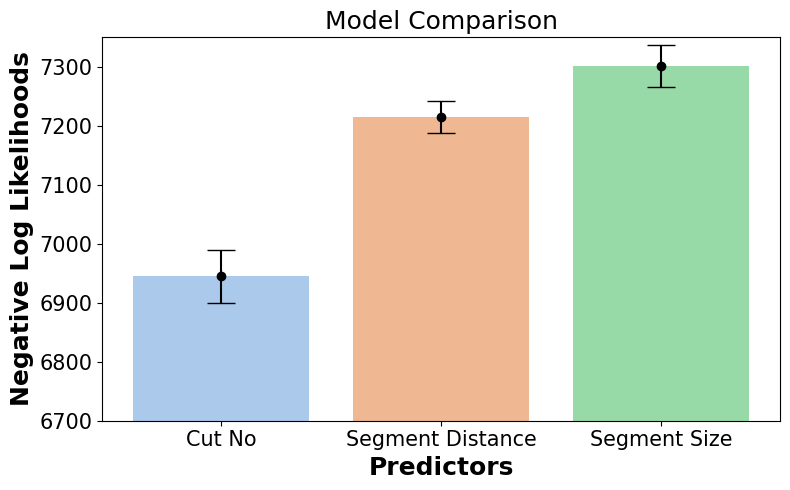

In [16]:
trgtDf = logLikeDf.groupby(['pred'], as_index=False).sum()
err = logLikeDf.groupby(['pred'], as_index=False).sem()

fig,ax = plt.subplots(figsize = (8,5))
sns.barplot(trgtDf['pred'], trgtDf['logLike'], palette='pastel')
ax.errorbar(trgtDf['pred'], trgtDf['logLike'], yerr=err['logLike'], fmt="o", color="k", capsize=10)



ax.set_ylabel('Negative Log Likelihoods', fontsize=18,fontweight='bold' )
ax.set_xlabel('Predictors', fontsize=18,fontweight='bold')
ax.set_xticklabels(['Cut No', 'Segment Distance', 'Segment Size'])
ax.set_title('Model Comparison', fontsize=18)
ax.set_ylim(6700, 7350)
ax.tick_params(axis='both', labelsize=15)
plt.tight_layout()

figname = 'figs/thesis/' +'psych_modelCompAgg.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

## Exposure Time Comparison

In [27]:
file_pth ='data/pilotData.csv'
pilotDf = pd.read_csv(file_pth)

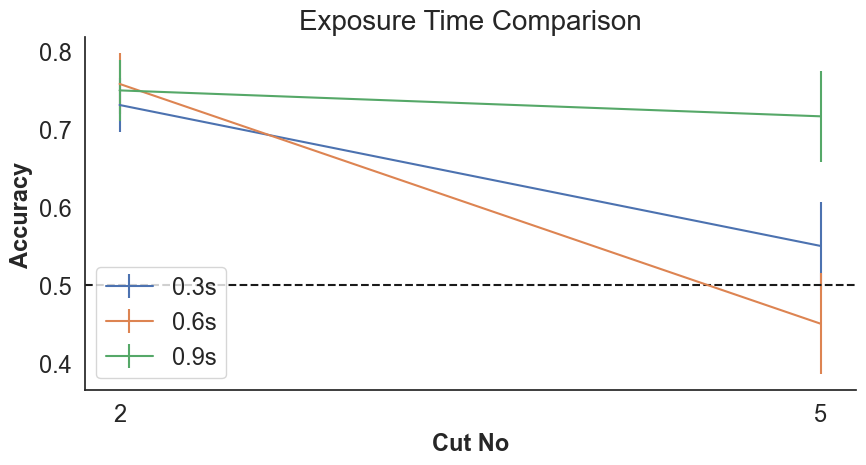

In [28]:
df_comp_cont0 = pilotDf[(pilotDf['cutNo']== 2) | (pilotDf['cutNo']== 5) & (pilotDf['control'] == 0)]

fig, ax = plt.subplots(figsize=(9,5))

error = df_comp_cont0.groupby(['cutNo','expTime'],as_index=False)['correct'].sem()
error_03 = error.loc[(error['expTime'] == 0.3), 'correct']
error_06 = error.loc[(error['expTime'] == 0.6), 'correct']
error_09 = error.loc[(error['expTime'] == 0.9), 'correct']
error_1 =  error.loc[(error['expTime'] == 1), 'correct']

y_mean = df_comp_cont0.groupby(['cutNo','expTime'],as_index=False)['correct'].mean()
y_mean_03 = y_mean.loc[(y_mean['expTime'] == 0.3),'correct']
y_mean_06 = y_mean.loc[(y_mean['expTime'] == 0.6),'correct']
y_mean_09 = y_mean.loc[(y_mean['expTime'] == 0.9),'correct']
y_mean_1 = y_mean.loc[(y_mean['expTime'] == 1),'correct']

x = [2,5]

# Compute upper and lower bounds
lower_03 = y_mean_03 - error_03
upper_03 = y_mean_03 + error_03

lower_06 = y_mean_06 - error_06
upper_06 = y_mean_06 + error_06

lower_09 = y_mean_09 - error_09
upper_09 = y_mean_09 + error_09

lower_1 = y_mean_1 - error_1
upper_1 = y_mean_1 + error_1

ax.errorbar(x, y_mean_03, yerr = error_03, label='0.3s')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.errorbar(x, y_mean_06, yerr = error_06, label='0.6s')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.errorbar(x, y_mean_09, yerr = error_09, label='0.9s')
ax.set_xlabel('Cut No', fontsize = fontSizeLabel, fontweight = 'bold')
ax.set_ylabel('Accuracy', fontsize = fontSizeLabel, fontweight = 'bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([2,5])
ax.axhline(0.5,ls = '--', color = 'k')    
ax.legend(loc = 'lower left', fontsize = fontSizeLegend)
ax.set_title('Exposure Time Comparison', fontsize = fontSizeTitle)
ax.tick_params(axis='both', which='major', labelsize=17)


plt.tight_layout()

figname = 'figs/thesis/ExpTimeComparison.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

## Multicolinearity Test with Heatmap

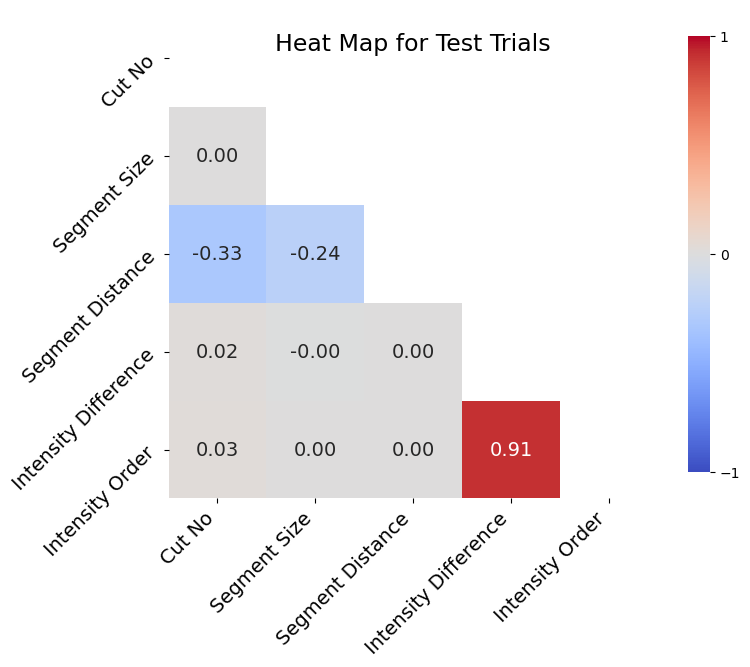

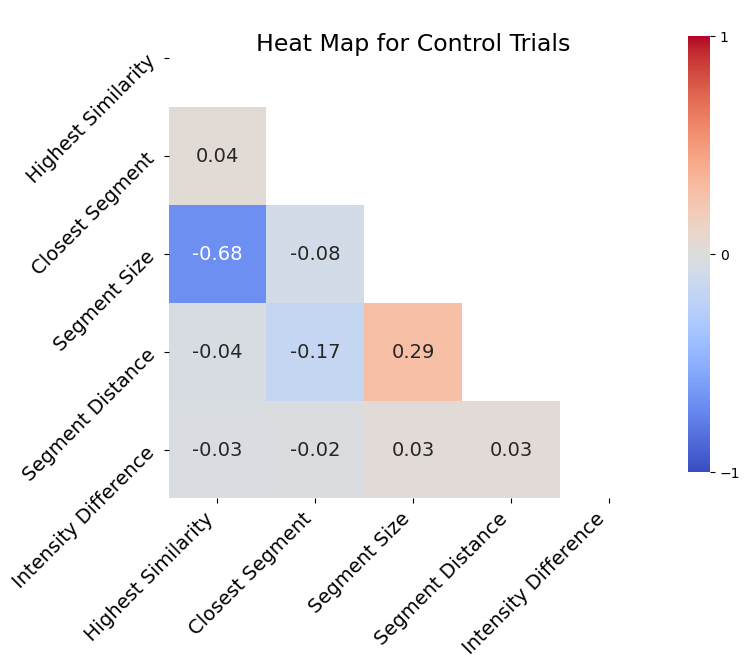

In [44]:
plt.figure(figsize=(8,8))
# Plot for the test trials
target_vars = ['cutNo','segSize','segCentDist',
                    'intDiff', 'intOrder']

trgt_df = df.loc[(df['control'] == 0) & (~df['participantID'].isin(['my', 'sw']))]

upp_mat = np.triu(trgt_df.loc[:,target_vars].corr())

ticklabels=['Cut No', 'Segment Size', 'Segment Distance', 'Intensity Difference', 'Intensity Order']
ax = sns.heatmap(trgt_df.loc[:,target_vars].corr(), annot = True, cmap = 'coolwarm', mask = upp_mat, fmt='.2f', vmin=-1, vmax=1, square = 1, annot_kws = {"size":14}, cbar_kws={"shrink": 0.65})
ax.set_xticklabels(ticklabels, fontdict={'fontsize': 14, 'horizontalalignment':'right'})
ax.set_yticklabels(ticklabels, fontdict={'fontsize': 14, 'horizontalalignment':'right'});
ax.tick_params(labelrotation=45) 
ax.set_title('Heat Map for Test Trials', fontsize = fontSizeTitle-3, y = 0.9)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])

plt.margins(x=0,y=0)
plt.tight_layout()
figname = 'figs/thesis/heatMap_test.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

plt.figure(figsize=(8,8))
# Plot for the control trials

target_vars = ['simScore','closestSeg','segSize','segCentDist','intDiff']
ticklabels=['Highest Similarity', 'Closest Segment', 'Segment Size', 'Segment Distance', 'Intensity Difference']

trgt_df = df.loc[(df['control'] == 1) & (~df['participantID'].isin(['my', 'sw']))]

upp_mat = np.triu(trgt_df.loc[:,target_vars].corr())

ax2 = sns.heatmap(trgt_df.loc[:,target_vars].corr(), annot = True, cmap = 'coolwarm', mask = upp_mat, fmt='.2f', square = 1, vmin=-1, vmax=1, annot_kws = {"size":14}, cbar_kws={"shrink": 0.65})
ax2.set_xticklabels(ticklabels, fontdict={'fontsize': 14, 'horizontalalignment':'right'})
ax2.set_yticklabels(ticklabels, fontdict={'fontsize': 14, 'horizontalalignment':'right'});
ax2.tick_params(labelrotation=45) 
ax2.set_title('Heat Map for Control Trials', fontsize = fontSizeTitle-3, y = 0.9)

cbar = ax2.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
plt.tight_layout()

figname = 'figs/thesis/heatMap_cntrl.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)
